In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy
from collections import Counter

# Seminar 5 - Federated Learning

Javier González Otero - 243078

Jordi Guillén González - 253027

David Sánchez Maldonado - 253798

## Part 0: Data preprocessing

In [8]:
file_path_clients = "data/client_datasets/"  # Path to the directory containing training data for each client

# Lists to store training features and labels DataFrames for each client
train_features_dfs = []
train_labels_dfs = []

# Loop over the 10 clients
for client_id in range(1, 11):
    # Load training features and labels for the current client
    features_df = pd.read_csv(f"{file_path_clients}client_{client_id}_features.csv", header=None)
    labels_df = pd.read_csv(f"{file_path_clients}client_{client_id}_labels.csv", header=None)

    # Append the loaded data to the lists
    train_features_dfs.append(features_df)
    train_labels_dfs.append(labels_df)

# Load test features and labels
test_features_df = pd.read_csv('data/test_features.csv', header=None)
test_labels_df = pd.read_csv('data/test_labels.csv', header=None)

**Check for missing values**

In [8]:
def check_missing_values(df):
    """
    Checks for missing (NaN) values in a DataFrame.

    Prints the total number of missing values and 
    the row indices where they occur, if any.
    """
    total_missing = df.isnull().sum().sum()
    
    if total_missing > 0:
        print(f"Missing values found: {total_missing}")
        missing_rows = df[df.isnull().any(axis=1)]
        print(f"Rows with missing values:\n{missing_rows.index.tolist()}")
    else:
        print("No missing values found.")


In [9]:
print("Checking training data (features and labels):")
for i in range(10):  # 10 clients
    print(f"\nClient {i+1}")
    print("- Features:")
    check_missing_values(train_features_dfs[i])
    print("- Labels:")
    check_missing_values(train_labels_dfs[i])
print("\nChecking test data (features and labels):")
print("- Features:")
check_missing_values(test_features_df)
print("- Labels:")
check_missing_values(test_labels_df)


Checking training data (features and labels):

Client 1
- Features:
No missing values found.
- Labels:
No missing values found.

Client 2
- Features:
No missing values found.
- Labels:
No missing values found.

Client 3
- Features:
No missing values found.
- Labels:
No missing values found.

Client 4
- Features:
No missing values found.
- Labels:
No missing values found.

Client 5
- Features:
No missing values found.
- Labels:
No missing values found.

Client 6
- Features:
No missing values found.
- Labels:
No missing values found.

Client 7
- Features:
No missing values found.
- Labels:
No missing values found.

Client 8
- Features:
No missing values found.
- Labels:
No missing values found.

Client 9
- Features:
No missing values found.
- Labels:
No missing values found.

Client 10
- Features:
No missing values found.
- Labels:
No missing values found.

Checking test data (features and labels):
- Features:
No missing values found.
- Labels:
No missing values found.


No cleaning is needed

**Show distribution of poses per client**

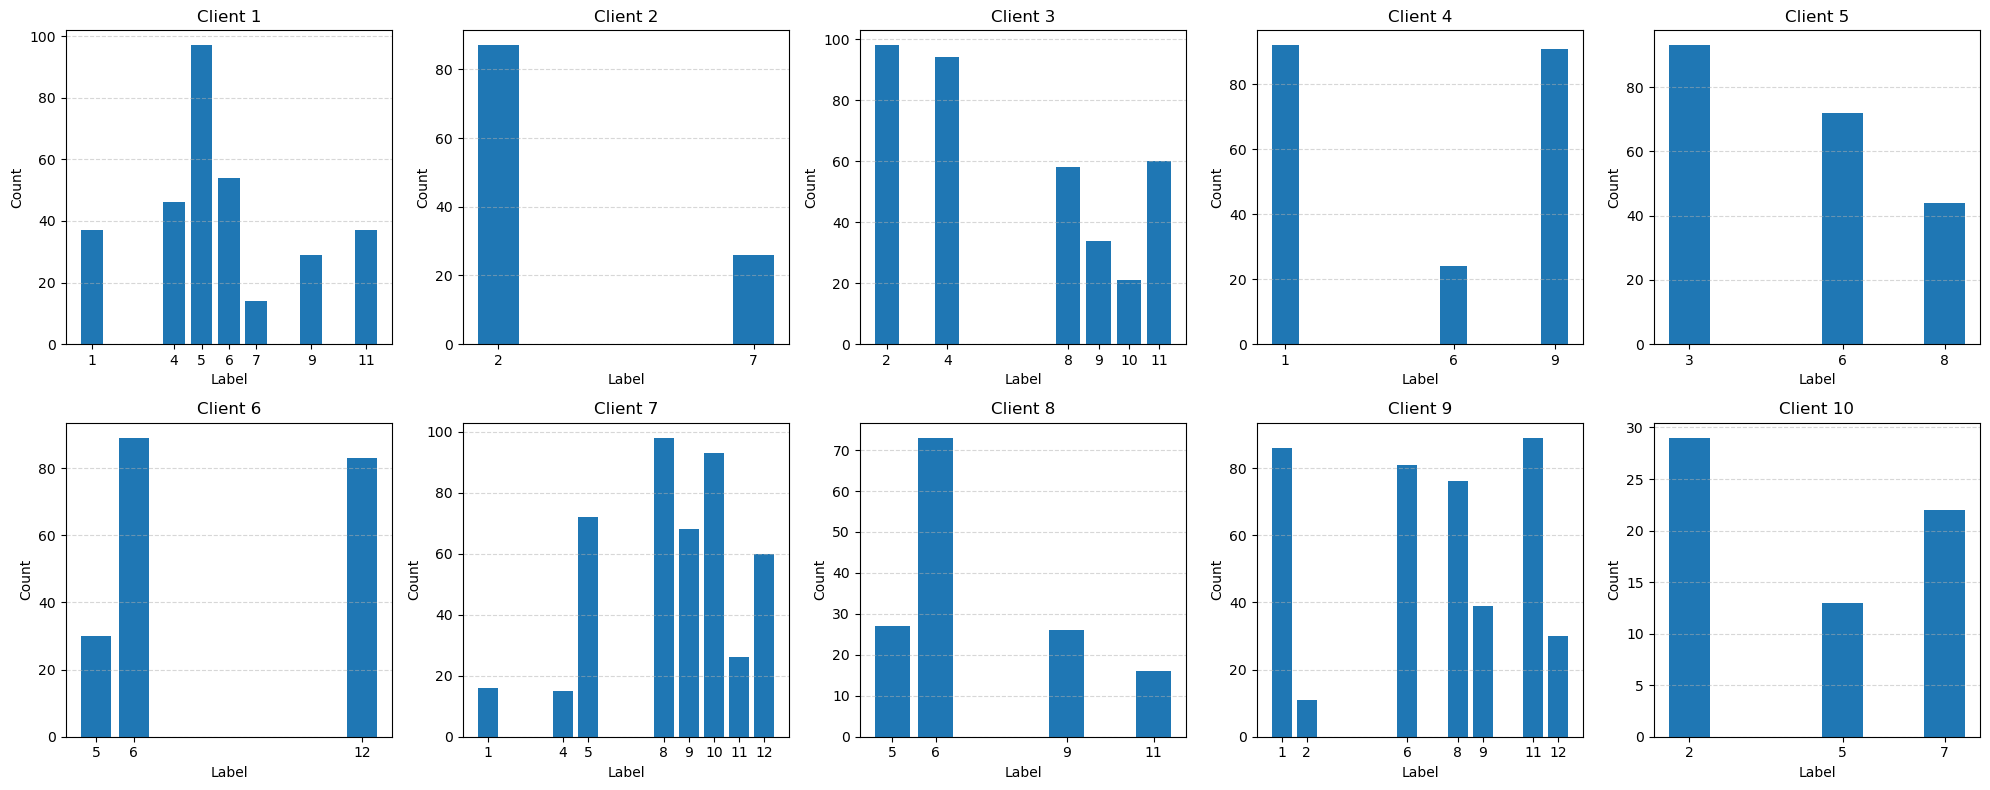

In [27]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows x 5 columns
axs = axs.flatten()  # Flatten the 2D array of axes for easy indexing

for i, labels_df in enumerate(train_labels_dfs):
    labels = labels_df.values.flatten()
    label_counts = Counter(labels)

    sorted_labels = sorted(label_counts.keys())
    counts = [label_counts[k] for k in sorted_labels]

    axs[i].bar(sorted_labels, counts)
    axs[i].set_title(f"Client {i + 1}")
    axs[i].set_xlabel("Label")
    axs[i].set_ylabel("Count")
    axs[i].set_xticks(sorted_labels)
    axs[i].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Data is not well balanced between clients, which may lead to generalization

## Part 1 - ML model preparation

A FC netwok is selected as ML model

In [17]:
class PoseClassifier(nn.Module):
    def __init__(self, input_dim=270, hidden_dim_1=128, output_dim=12):
        super(PoseClassifier, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, output_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.03)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        return self.fc2(x)  # logits (CrossEntropyLoss applies softmax internally)


## Part 2 - Preparation of the FL setting

To perform a realistic simulation of the FL environment, clients must be instantiated separately from orchestrator, hence, we create an independent class for treatig their data and training.

In [27]:
class Client:
    def __init__(self, client_id, X_train, y_train, local_epochs=5, local_batch_size=32, local_lr=0.01):
        """
        Client object for federated learning.

        Parameters
        ----------
        client_id : int
            Unique client identifier.
        X_train : pd.DataFrame
            Local feature data.
        y_train : pd.DataFrame
            Local labels.
        local_epochs : int
            Number of epochs for local training.
        local_batch_size : int
            Batch size for local training.
        local_lr : float
            Learning rate for local optimizer.
        """
        self.id = client_id
        self.X_train = X_train
        self.y_train = y_train
        self.local_epochs = local_epochs
        self.local_batch_size = local_batch_size
        self.local_lr = local_lr

    def local_train(self, global_model):
        """
        Trains a local copy of the global model on the client's private data.

        Parameters
        ----------
        global_model : torch.nn.Module
            The global model whose weights are used to initialize the local copy.

        Returns
        -------
        state_dict : dict
            Trained model parameters.
        num_samples : int
            Number of training samples used.
        """
        # Create and initialize local model
        model = type(global_model)()
        model.load_state_dict(global_model.state_dict())

        # Prepare optimizer and loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=self.local_lr, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()

        # Preprocess data: standardize locally
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X_train)
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

        # Ensure labels are 0-based and 1D
        y_array = self.y_train.values.flatten() - 1
        y_tensor = torch.tensor(y_array, dtype=torch.long)

        # Build DataLoader
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=self.local_batch_size, shuffle=True)

        # Local training loop
        model.train()
        for epoch in range(self.local_epochs):
            total_loss = 0
            for xb, yb in loader:
                optimizer.zero_grad()
                logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            #avg_loss = total_loss / len(loader)
            #print(f"Client {self.id} | Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

        return model.state_dict(), len(self.X_train)

Federated AVG is selected as aggregation strategy

In [29]:

def fed_avg(weight_updates, sizes):
    """
    FedAvg with correct handling of float tensors only.
    """
    total_size = sum(sizes)
    avg_weights = deepcopy(weight_updates[0])

    for key in avg_weights:
        if avg_weights[key].dtype not in (torch.float32, torch.float64):
            continue  # Skip non-float parameters (like batchnorm counters)

        avg_weights[key] = sum(
            (client_state[key].float() * (size / total_size))
            for client_state, size in zip(weight_updates, sizes)
        )

    return avg_weights

An orchestrator class is defined to organize the distributed training process. Orchestrator does not have access to clients data.

In [30]:
class Orchestrator:
    def __init__(self, clients, model_class, num_fl_rounds, tolerance_fl, input_dim=270, hidden_dim_1=128, output_dim=12):
        """
        Parameters
        ----------
        clients : list of Client
            List of clients that contain and manage their own data.
        model_class : callable
            The PyTorch model class to instantiate the global model.
        num_fl_rounds : int
            Number of global federated training rounds.
        tolerance_fl : float
            Minimum weight change threshold to consider convergence.
        input_dim, hidden_dim_1, output_dim : int
            Architecture parameters for the model.
        """
        self.clients = clients
        self.model_class = model_class
        self.num_fl_rounds = num_fl_rounds
        self.tolerance_fl = tolerance_fl
        self.input_dim = input_dim
        self.hidden_dim_1 = hidden_dim_1
        self.output_dim = output_dim
        self.global_model = None

    def initialize_model(self):
        """Initializes a fresh instance of the global model."""
        self.global_model = self.model_class(
            input_dim=self.input_dim,
            hidden_dim_1=self.hidden_dim_1,
            output_dim=self.output_dim
        )

    def select_clients(self, num_clients):
        """Randomly selects a subset of clients for a given round."""
        return random.sample(self.clients, num_clients)

    def run_federated_training(self, fedavg_fn, clients_per_round=None):
        """
        Runs the Federated Learning process over several rounds.

        Parameters
        ----------
        fedavg_fn : function
            Function that aggregates model weights using FedAvg.
        clients_per_round : int or None
            Number of clients per round (defaults to using all).
        """
        if clients_per_round is None:
            clients_per_round = len(self.clients)

        prev_weights = None

        for round_num in range(self.num_fl_rounds):
            print(f"\n[Round {round_num + 1}] Selecting clients...")
            selected_clients = self.select_clients(clients_per_round)
            #print('selected clients: ', selected_clients)

            print(f"[Round {round_num + 1}] Training local models...")
            updates = []
            sizes = []
            for client in selected_clients:
                weights, size = client.local_train(self.global_model)
                updates.append(weights)
                sizes.append(size)

            print(f"[Round {round_num + 1}] Aggregating with FedAvg...")
            avg_weights = fedavg_fn(updates, sizes)
            #print(self.global_model.state_dict())
            self.global_model.load_state_dict(avg_weights)
            #print(self.global_model.state_dict())

            if prev_weights is not None:
                deltas = sum(
                    torch.norm(avg_weights[k].float() - prev_weights[k].float()).item()
                    for k in avg_weights
                    if avg_weights[k].dtype in (torch.float32, torch.float64)
                )

                print(f"[Round {round_num + 1}] Weight change: {deltas:.6f}")
                if deltas < self.tolerance_fl:
                    print("[Convergence reached]")
                    break

            prev_weights = {k: v.clone().detach() for k, v in avg_weights.items()}

## Part 3 - Collaborative training of the model

Hyperparameter setting: We have decided to perform 100 rounds of FL as we saw that global model's weights did not converge with low number of FL rounds. (With this high number of FL rounds neither). 8 clients were selected per round due to the fact that there are some clients with poorly balanced data, hence reducing the number of clients per round would lead to overfitting within that round and hence not converging global weights. Architecture of our FC presents a funnel structure, with an intermediate layer of 128 neurons. A total of 200 epochs were performed for every client, as by experimentation it turned out to provide slightly better results.

In [32]:
# Global FL hyperparameters
NUM_FL_ROUNDS = 100
TOLERANCE_FL = 1e-3
CLIENTS_PER_ROUND = 8
INPUT_DIM = 270
HIDDEN_DIM_1 = 128
OUTPUT_DIM = 12

# Local training hyperparameters per client
LOCAL_EPOCHS = 200
LOCAL_BATCH_SIZE=32
LOCAL_LR = 0.001

In [34]:

clients = []

for i in range(10):
    client = Client(
        client_id=i + 1,
        X_train=train_features_dfs[i],
        y_train=train_labels_dfs[i],
        local_epochs=LOCAL_EPOCHS,
        local_batch_size=LOCAL_BATCH_SIZE,
        local_lr=LOCAL_LR
    )
    clients.append(client)


In [37]:
# Initialize the central FL orchestrator
orchestrator = Orchestrator(
    clients=clients,
    model_class=PoseClassifier,
    num_fl_rounds=NUM_FL_ROUNDS,
    tolerance_fl=TOLERANCE_FL,
    input_dim=INPUT_DIM,
    hidden_dim_1=HIDDEN_DIM_1,
    output_dim=OUTPUT_DIM
)

# Instantiate the global model
orchestrator.initialize_model()

In [39]:
# Start federated training across rounds
orchestrator.run_federated_training(
    fedavg_fn = fed_avg,
    clients_per_round=CLIENTS_PER_ROUND
)


[Round 1] Selecting clients...
[Round 1] Training local models...
[Round 1] Aggregating with FedAvg...

[Round 2] Selecting clients...
[Round 2] Training local models...
[Round 2] Aggregating with FedAvg...
[Round 2] Weight change: 5.539872

[Round 3] Selecting clients...
[Round 3] Training local models...
[Round 3] Aggregating with FedAvg...
[Round 3] Weight change: 3.813639

[Round 4] Selecting clients...
[Round 4] Training local models...
[Round 4] Aggregating with FedAvg...
[Round 4] Weight change: 2.799343

[Round 5] Selecting clients...
[Round 5] Training local models...
[Round 5] Aggregating with FedAvg...
[Round 5] Weight change: 2.153313

[Round 6] Selecting clients...
[Round 6] Training local models...
[Round 6] Aggregating with FedAvg...
[Round 6] Weight change: 1.986720

[Round 7] Selecting clients...
[Round 7] Training local models...
[Round 7] Aggregating with FedAvg...
[Round 7] Weight change: 1.619108

[Round 8] Selecting clients...
[Round 8] Training local models...
[

The global model did not converge, however, the model gave much better results when not trained distributely, but we were not able to find where does the problem come from.

In [42]:
# Load test set from CSV
test_features_df = pd.read_csv('data/test_features.csv', header=None)
test_labels_df = pd.read_csv('data/test_labels.csv', header=None)


In [43]:
def evaluate_model(model, X_test_df, y_test_df):
    """
    Evaluates the global model on the provided test dataset.

    This function computes predictions using the trained model and compares them 
    against the ground truth labels, returning the overall accuracy and confusion matrix.

    Parameters
    ----------
    model : torch.nn.Module
        The trained PyTorch model (e.g., global model after federated training).
    X_test_df : pd.DataFrame
        Test set features with shape (n_samples, n_features).
    y_test_df : pd.DataFrame
        Test set labels with values in the range [1, 12].

    Returns
    -------
    None
        Prints test accuracy and displays the confusion matrix.
    
    Notes
    -----
    Labels are shifted to the range [0, 11] before evaluation to match model output indexing.
    """
    model.eval()
    X_tensor = torch.tensor(X_test_df.values, dtype=torch.float32)
    y_true = y_test_df.values.ravel() - 1  # Convert labels to 0-based indexing

    with torch.no_grad():
        logits = model(X_tensor)
        y_pred = torch.argmax(logits, dim=1).numpy()

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n🧪 Final Test Accuracy: {acc:.4f}")
    print("📊 Confusion Matrix:")
    print(cm)

In [44]:
# Run evaluation
evaluate_model(orchestrator.global_model, test_features_df, test_labels_df)


🧪 Final Test Accuracy: 0.1480
📊 Confusion Matrix:
[[ 1 21  0  5  1 12  0  0 14  0  2  1]
 [ 0 22  0 11  1  9  0  0  3  0  2  3]
 [ 0 21  0  8  0 16  0  0  0  0  5  6]
 [ 0 18  0  9  4  8  0  0  1  0  3  4]
 [ 0 23  0  1  7  8  0  0  8  0  0  3]
 [ 0 17  0  8  3 17  0  0  0  0  1  1]
 [ 0 14  0  4  1  9  0  0  3  0  1  5]
 [ 0  8  0  2  0  5  0  0  1  0  1  0]
 [ 0  4  0  3  0  1  0  0  4  0  0  0]
 [ 0 34  0  2  3 13  0  0  0  4  5  2]
 [ 0 24  0  4  1  5  0  0  5  0  9  4]
 [ 0  7  0  0  0  2  0  0  0  0  1  1]]


Confusion matrix shows that there are some poses (2, 6, 8) for which the model did not give any results.

We think that overfitting of local models may be the cause of this, as **client data is not well balanced**, having some clients featuring a very low number of poses. This can  be seen below.